In [1]:
import math
import re
import random
import sys
import time
import zstandard as zstd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from typing import Union, Dict, List
from collections import Counter
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import font_manager

In [2]:
# 对输入字符串进行分词处理，将字符串转化为小写并用非单词字符进行分割
def tokenize(s: str) -> list:
    return re.split(r'\W+', s.lower())

In [3]:
# 规范化输入字符串，移除多余的空白和非单词字符
def normalize(s: str) -> str:
    s0 = re.sub(r'\b\W+ | \W+\b', ' ', s.lower())
    return re.sub(r'\b[^\w\s]+\b', '', s0)

In [4]:
# 字符串规范化类
class StringNormalizer:
    def __init__(self, no_punct: bool = False, keep_punct: bool = False):
        self.patterns_to_replace = []
        # 根据参数决定是否去除标点符号
        if no_punct:
            self.patterns_to_replace += [('[¿?#!¡_]+|\.\.\.+', ' ')]
        else:
            if keep_punct is False:
                self.patterns_to_replace += [
                    ('\.\.\.+', ' ___ '),  # 替换省略号
                    ('[¿?]+', ' _?_ '),    # 替换问号
                    ('[!¡]+', ' _!_ '),    # 替换感叹号
                    ('#', " _#_ "),        # 替换井号
                ]
        
        # 定义其他替换模式
        self.patterns_to_replace += [
            ('[^\w\d?!_*&|#]+', ' '),  # 移除非单词字符
            ("(?<=\w)[’']+(?=\w)|(?<=\d)[,._\s]+(?=\d)", ''),  # 处理数字间的标点
            ('(?<!\d)\d\d?(?!\d)', ' ## '),  # 替换小于三位的数字
            ('(?<!\d)\d+(?!\d)', ' ### '),  # 替换多位数字
            ('\s+', ' ')  # 替换多个空格为一个空格
        ]

    # 规范化字符串
    def normalize_str(self, text: str):
        t = f' {text} '  # 在字符串开头和结尾添加空格以便后续处理
        for p in self.patterns_to_replace:
            t = re.sub(p[0], p[1], t)  # 应用所有替换模式
        return t[1:-1]  # 返回处理后的字符串，去除前后的空格

    # 从规范化字符串中提取单词
    def get_words(self, text: str):
        norm_text = self.normalize_str(text)
        return re.findall('\W*(\w+)', norm_text)  # 使用正则表达式提取单词

    # 获取单词计数
    def get_word_count(self, text: str):
        return len(self.get_words(text))  # 返回单词数量


In [5]:
# 字符计数类
class CharCounter:
    def __init__(self,
                 samples: list,
                 name='',
                 IDF_thresh: float = 0.005,
                 max_samples: int = 50000):
        self.name = name
        self.IDF_thresh = IDF_thresh
        self.num_samples = min(max_samples, len(samples))  # 限制样本数
        self.populate_char_ctrs(samples[:max_samples], IDF_thresh)  # 填充字符计数器

        print(f"{len(self.good_chars)} 个有效字符: ", self.good_chars)
        print(f"{len(self.leftover_chars)} 个剩余字符: ", self.leftover_chars)

        prob = self.compute_total_char_prob()
        if prob < 0.99:
            print("警告: 在 CharCounter 中，总概率为", prob, "(应为 1.0)")

    # 返回字符计数器的字符串表示
    def __str__(self):
        return (f"字符计数器 *{self.name}* 基于 {self.num_samples} 个样本"
                f" 和 {self.num_chars} 个字符"
                f"\n按 DF 阈值 {100 * self.IDF_thresh:.3}% 排序的字符"
                f"(空格 + 字符):\n {self.ctr_df_trimmed}"
                f"\n按出现次数排序的字符:\n {self.ctr_occ_trimmed}"
                f"\n剩余字符: {self.leftover_chars}")

    # 获取字符计数
    @staticmethod
    def get_char_counts(titles: list):
        ctr_df = Counter()  # 计数器，记录字符的出现频率
        ctr_occ = Counter()  # 计数器，记录字符的总出现次数
        OK_chars = re.compile('[^\w\d .,:;¿?¡!_*+/|#]+')  # 允许的字符正则表达式
        for t in titles:
            try:
                tn = re.sub(OK_chars, '', t)  # 移除不允许的字符
            except TypeError:
                print(t)
                print(type(t))
                return
            ctr_df += Counter(set(tn))  # 统计不重复字符
            ctr_occ += Counter(tn)  # 统计字符的出现次数
        return ctr_df, ctr_occ

    # 填充字符计数器
    def populate_char_ctrs(self, samples: list, IDF_thresh: float):
        n = len(samples)
        self.ctr_df, self.ctr_occ = self.get_char_counts(samples)  # 获取字符计数
        print("找到", len(self.ctr_df), "种不同字符（单词、标点符号、空格），不包括表情符号")
        self.ctr_df_trimmed = Counter()  # 修剪后的字符计数器
        self.ctr_occ_trimmed = Counter()  # 修剪后的字符出现次数计数器
        for chr, count in self.ctr_df.most_common(int(10 / IDF_thresh)):  # 根据阈值修剪字符
            self.ctr_df_trimmed[chr] = count
            self.ctr_occ_trimmed[chr] = self.ctr_occ[chr]
            self.min_occ = self.ctr_occ[chr]
            if count < n * IDF_thresh: break
        self.num_chars = sum(self.ctr_occ_trimmed.values())  # 计算总字符数
        self.good_chars = ''.join([c for c in self.ctr_df_trimmed])  # 有效字符集合
        self.leftover_chars = ''.join([c for c in self.ctr_df - self.ctr_df_trimmed])  # 剩余字符集合
        self.bad_chars_regex = re.compile('[^' + self.good_chars + ']+')  # 无效字符正则表达式

    # 移除无效字符
    def remove_bad_chars(self, s: str):
        return re.sub('\s+', ' ', re.sub(self.bad_chars_regex, '', s))

    # 计算交叉熵
    def compute_cross_entropy(self, s: str):
        if len(s) == 0: return 0.0
        sum_lp = 0
        for c in s:
            p = self.get_char_prob(c)
            sum_lp += math.log(p)
        return -sum_lp / len(s)

    # 计算基于有效字符的交叉熵
    def compute_cross_entropy1(self, s: str):
        s1 = self.remove_bad_chars(s)  # 移除无效字符
        if len(s1) == 0: return 0.0
        sum_lp = 0
        for c in s1:
            p = self.get_char_prob(c)
            sum_lp += math.log(p)
        return -sum_lp / len(s1)

    # 获取字符的概率
    def get_char_prob(self, c: str):
        count = self.ctr_occ_trimmed[c]  # 获取字符出现次数
        if count == 0:
            count = self.min_occ / 2.0  # 若字符未出现，则使用最小出现次数的一半
        return count / self.num_chars  # 返回字符概率

    # 计算字符的总概率
    def compute_total_char_prob(self):
        sum = 0.0
        for c in self.ctr_occ_trimmed:
            sum += self.get_char_prob(c)
        return sum  # 返回字符总概率

In [6]:
# 单词计数类
class WordCounter:
    def __init__(self,
                 samples: list,
                 name='',
                 IDF_thresh: float = 0.0001,
                 max_samples: int = 50000):
        self.name = name
        self.IDF_thresh = IDF_thresh
        self.num_samples = min(max_samples, len(samples))  # 限制样本数
        self.populate_word_ctrs(samples[:max_samples], IDF_thresh)  # 填充单词计数器

        prob = self.compute_total_word_prob()
        if prob < 0.99:
            print("警告：在 WordCounter 中，总概率为", prob, "（应该为 1.0）")

    # 返回单词计数器的字符串表示
    def __str__(self):
        return (f"单词计数器 *{self.name}* 基于 {self.num_samples} 个样本"
                f" 和 {self.num_words} 个单词构建"
                f"\n根据 DF 阈值 {100 * self.IDF_thresh:.3}% 的最高频单词: {self.ctr_df_trimmed}"
                f"\n根据出现次数的最高频单词:\n {self.ctr_occ_trimmed}")

    # 获取单词计数
    @staticmethod
    def get_word_counts(titles: list):
        ctr_df = Counter()  # 计数器，记录单词的出现频率
        ctr_occ = Counter()  # 计数器，记录单词的总出现次数
        for t in titles:
            words = t.split()  # 按空格分割单词
            ctr_df += Counter(set(words))  # 统计不重复单词
            ctr_occ += Counter(words)  # 统计单词的出现次数
        return ctr_df, ctr_occ

    # 填充单词计数器
    def populate_word_ctrs(self, samples: list, IDF_thresh: float):
        n = len(samples)
        self.ctr_df, self.ctr_occ = self.get_word_counts(samples)  # 获取单词计数
        print("找到", len(self.ctr_df), "个不同的单词")
        self.ctr_df_trimmed = Counter()  # 修剪后的单词计数器
        self.ctr_occ_trimmed = Counter()  # 修剪后的单词出现次数计数器
        for w, count in self.ctr_df.most_common(int(10 / IDF_thresh)):  # 根据阈值修剪单词
            self.ctr_df_trimmed[w] = count
            self.ctr_occ_trimmed[w] = self.ctr_occ[w]
            self.min_occ = self.ctr_occ[w]
            if count < n * IDF_thresh: break
        self.num_words = sum(self.ctr_df_trimmed.values())  # 计算总单词数
        print(f"修剪后剩余 {len(self.ctr_df_trimmed)} 个单词")

    # 移除罕见单词
    def remove_rare_words(self, s: str):
        words = s.split()
        new_words = [w for w in words if self.ctr_df_trimmed[w] > 0]  # 保留出现次数大于0的单词
        return ' '.join(new_words)  # 返回新字符串

    # 计算单词的交叉熵
    def compute_cross_entropy(self, s: str):
        if len(s) == 0: return 0.0
        words = s.split()
        sum_lp = 0
        for c in words:
            p = self.get_word_prob(c)
            sum_lp += math.log(p)
        return -sum_lp / len(words)

    # 计算基于频繁单词的交叉熵
    def compute_cross_entropy1(self, s: str):
        if len(s) == 0: return 0.0
        words = s.split()
        new_words = [w for w in words if self.ctr_df_trimmed[w] > 0]  # 保留出现次数大于0的单词
        if len(new_words) == 0: return 0.0
        sum_lp = 0
        for c in new_words:
            p = self.get_word_prob(c)
            sum_lp += math.log(p)
        return -sum_lp / len(new_words)

    # 获取单词的概率
    def get_word_prob(self, word: str):
        count = self.ctr_occ_trimmed[word]  # 获取单词出现次数
        if count == 0:
            count = self.min_occ / 2  # 若单词未出现，则使用最小出现次数的一半
        return count / self.num_words  # 返回单词概率

    # 计算单词的总概率
    def compute_total_word_prob(self):
        sum = 0.0
        for word in self.ctr_occ_trimmed:
            sum += self.get_word_prob(word)
        return sum  # 返回单词总概率


In [7]:
# 清理字符串，使用字符串规范化器和字符计数器
def cleanup_str(s: str, string_normalizer=None, char_ctr=None):
    return string_normalizer.normalize_str(char_ctr.remove_bad_chars(s))

# 清理语料库，遍历每个样本
def cleanup_corpus(corpus: list, string_normalizer=None, char_ctr=None):
    return [cleanup_str(s, string_normalizer, char_ctr) for s in corpus]  # 返回清理后的语料库

In [8]:
def get_hashed_words(s: str):
    """
    将输入字符串中的每个单词转换为其哈希值的字节表示。
    该函数返回一个字节序列，每个单词用其哈希值的字节表示。
    
    :param s: 输入字符串
    :return: 表示单词哈希值的字节序列
    """
    bytes_list = []  # 用于存储每个单词的字节表示
    for w in s.split():
        if w == '': 
            continue  # 跳过空字符串
        h = hash(w)  # 获取单词的哈希值
        while h > 0:
            # 将哈希值转换为字节，范围为1到255
            bytes_list.append(1 + h % 255)  # 255而不是256，以便0可以作为单词分隔符
            h = h // 255  # 更新哈希值，向下取整
        bytes_list.append(0)  # 添加字节0作为结束符
    return bytes(bytes_list)  # 返回字节序列

In [9]:
class ZstdLangModel:
    """
    Zstandard语言模型，用于文本压缩。
    假设输入已经过预处理（归一化等）。
    """

    ZSTD_LEVEL = 22  # 压缩级别
    dict_size_factor = 3 / 5  # 字典大小因子
    verbose = 0  # 是否输出详细信息
    max_num_dicts = 7  # 最大字典数量
    min_dict_size = 150  # 最小字典大小（字节）
    compression_threshold = 0.9  # 压缩效果阈值

    def __init__(self, name: str, corpus: list, primary_dict_size: int = 0, hash_words: bool = False):
        """
        初始化Zstd语言模型。

        :param name: 模型名称
        :param corpus: 训练语料库
        :param primary_dict_size: 主字典大小
        :param hash_words: 是否对单词进行哈希处理
        """
        if self.verbose > 0:
            print(f'对于"{name}"语料库，大小为 {len(corpus)}: ')
            not_str = '' if hash_words else ' 未'
            print(f'  * 单词{not_str}哈希化')  # 输出是否对单词进行哈希处理
        self.name = name  # 保存模型名称
        self.primary_dict_size = primary_dict_size  # 设置主字典大小
        self.hash_words = hash_words  # 设置是否哈希单词

        self.set_params(corpus)  # 设置参数
        #self.train_dicts(corpus)  # 训练字典
        self.train_new_dicts(corpus) #创新后的训练

    def set_params(self, corpus: list):
        """
        设置模型参数，包括主字典大小和字典数量。

        :param corpus: 训练语料库
        """
        # 如果需要哈希单词，则生成字节对象列表
        if self.hash_words:
            self.bytes_obj_list = [get_hashed_words(s) + b'|' for s in corpus]
            corpus_b = b''.join(self.bytes_obj_list)  # 连接所有字节
        else:
            corpus_b = bytes('\n'.join(corpus), 'utf8')  # 将文本语料库转换为字节

        orig_size = len(corpus_b)  # 记录原始大小
        self.c = zstd.ZstdCompressor(level=self.ZSTD_LEVEL)  # 创建压缩器
        compr_size = len(self.c.compress(corpus_b))  # 获取压缩后的大小
        del corpus_b  # 删除临时字节对象以释放内存

        # 如果未指定主字典大小，则根据压缩后的大小计算
        if self.primary_dict_size == 0:
            self.primary_dict_size = int(self.dict_size_factor * compr_size)

        # 计算字典数量
        self.num_dicts = max(min(
            self.max_num_dicts,
            int(math.log2(self.primary_dict_size / self.min_dict_size))), 1)

        if self.verbose > 0:
            print(
                f'  * 压缩率 = {compr_size / orig_size:.4}, 压缩后大小 {compr_size}'
            )  # 输出压缩率

    def train_dicts(self, corpus: list):
        """
        训练字典。

        :param corpus: 训练语料库
        """
        samples = self.bytes_obj_list if self.hash_words else [
            bytes(s, 'utf8') for s in corpus  # 将语料库转换为字节格式
        ]

        def get_dict(j: int, primary_dict_size: int, samples: list):
            """
            生成指定大小的训练字典。

            :param j: 字典索引
            :param primary_dict_size: 主字典大小
            :param samples: 样本数据
            :return: 训练生成的字典
            """
            sz = max(int(primary_dict_size / 2**j), 256)  # 确定字典大小
            return zstd.train_dictionary(sz, samples)  # 训练并返回字典

        if self.verbose:
            print(
                f'  * 构建 {self.num_dicts} 个字典，大小为 {self.primary_dict_size} 或更小'
            )  # 输出正在构建的字典数量和大小

        # 生成字典列表
        self.dicts = [
            get_dict(j, self.primary_dict_size, samples)
            for j in range(self.num_dicts)
        ]

        # 创建压缩器上下文，忽略各种头部信息
        self.cctx = [
            zstd.ZstdCompressor(
                dict_data=d,
                write_content_size=False,
                write_dict_id=False,
                write_checksum=False,
                level=self.ZSTD_LEVEL) for d in self.dicts
        ]

        self.header_size = len(self.cctx[0].compress(b''))  # 计算压缩头部大小
        if self.verbose > 0:
            print('  * 压缩头部大小为', self.header_size,
                  '将被忽略')  # 输出将忽略的头部大小

        if self.hash_words: 
            del self.bytes_obj_list  # 删除字节对象列表以释放内存

        return

    def get_compr_size(self, t: str):
        """
        获取给定文本的压缩大小。

        :param t: 输入文本
        :return: 压缩大小和原始大小
        """
        t_b = bytes(t, 'utf8')  # 将文本转换为字节
        l_orig = len(t_b)  # 原始大小
        if l_orig < 5: 
            return l_orig, l_orig  # 若文本长度小于5，则直接返回原始大小

        if self.hash_words:
            t_b = get_hashed_words(t)  # 对文本进行哈希处理

        # 计算压缩后的大小
        l_compr = sum([len(c.compress(t_b))
                       for c in self.cctx]) / len(self.cctx) - self.header_size
        l_orig = len(self.c.compress(t_b)) - self.header_size  # 计算原始压缩大小
        return l_compr, l_orig  # 返回压缩大小和原始大小


    def train_new_dicts(self, corpus: list):
        """
        创新：训练字典并动态缩小字典大小。

        :param corpus: 训练语料库
        """
        samples = self.bytes_obj_list if self.hash_words else [
            bytes(s, 'utf8') for s in corpus
        ]

        current_dict_size = self.primary_dict_size  # 初始字典大小
        self.dicts = []  # 存储生成的字典

        for j in range(self.num_dicts):
            # 生成指定大小的字典
            sz = max(int(current_dict_size), 256)
            dict_data = zstd.train_dictionary(sz, samples)
            self.dicts.append(dict_data)
            
            # 创建测试压缩器并计算压缩效果
            test_compressor = zstd.ZstdCompressor(dict_data=dict_data)
            test_compr_size = sum(len(test_compressor.compress(s)) for s in samples) / len(samples)
            
            if self.verbose:
                print(f'第 {j+1} 个字典大小为 {sz}，平均压缩效果: {test_compr_size}')

            # 根据压缩效果动态调整下一轮字典大小
            if test_compr_size < self.compression_threshold * len(b''.join(samples)):
                current_dict_size *= self.dict_size_factor  # 动态缩小字典
            else:
                print("压缩效果达到阈值，停止缩小字典")
                break

        # 创建压缩器上下文，忽略各种头部信息
        self.cctx = [
            zstd.ZstdCompressor(
                dict_data=d,
                write_content_size=False,
                write_dict_id=False,
                write_checksum=False,
                level=self.ZSTD_LEVEL
            ) for d in self.dicts
        ]

        # 计算压缩头部大小
        self.header_size = len(self.cctx[0].compress(b''))
        if self.verbose:
            print('  * 压缩头部大小为', self.header_size, '将被忽略')

        if self.hash_words:
            del self.bytes_obj_list  # 删除字节对象列表以释放内存

In [10]:
class Zstd2Classifier:
    """
    Zstandard分类器，使用ZstdLangModel进行分类。
    假设输入已经过预处理（归一化等）。
    """

    verbose = 0  # 是否输出详细信息

    def __init__(self, name: str, pos_samples: list, neg_samples: list, hash_words: bool = False):
        """
        初始化分类器。

        :param name: 分类器名称
        :param pos_samples: 正样本列表
        :param neg_samples: 负样本列表
        :param hash_words: 是否对单词进行哈希处理
        """
        if self.verbose > 0:
            print(
                f'构建 "{name}" 分类器，包含 {len(pos_samples)} 个正样本和 '
                f'{len(neg_samples)} 个负样本')  # 输出构建分类器的信息

        # 创建正负样本的Zstd语言模型
        self.pos_model = ZstdLangModel('positive', pos_samples, 0, hash_words)
        self.neg_model = ZstdLangModel('negative', neg_samples,
                                       self.pos_model.primary_dict_size, hash_words)

    def score(self, s: str, num_reps: int = 2):
        """
        对给定字符串进行评分。

        :param s: 输入字符串
        :param num_reps: 字符串重复次数
        :return: 分类得分、负样本压缩率、正样本压缩率
        """
        s_x = s * num_reps  # 重复输入字符串
        # 获取正负样本的压缩大小和原始大小
        compr_sz_pos, orig_sz_pos = self.pos_model.get_compr_size(s_x)
        compr_sz_neg, orig_sz_neg = self.neg_model.get_compr_size(s_x)
        assert orig_sz_pos == orig_sz_neg, '两个原始大小估计值不同'  # 确保原始大小一致
        if orig_sz_pos == 0:
            return 0.0, 1.0, 1.0  # 若原始大小为0，返回默认值

        # 计算正负样本的压缩率
        pos_rate = compr_sz_pos / orig_sz_pos
        neg_rate = compr_sz_neg / orig_sz_neg

        score = neg_rate - pos_rate  # 计算分类得分
        return score, neg_rate, pos_rate  # 返回得分和压缩率

In [11]:
import os

# 列出 /kaggle/input/ 目录下的文件
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/chinese/DroidSansFallback.ttf
/kaggle/input/mydatanlp/news-article-categories.csv
/kaggle/input/mydatanlp/uci-news-aggregator.csv
/kaggle/input/mydatanlp/clickbait_data.csv


In [12]:
df = pd.read_csv('/kaggle/input/mydatanlp/clickbait_data.csv')

In [13]:
df

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [14]:
# 提取标题数据
cb_pos = df[df.clickbait == 1].headline.values
cb_neg = df[df.clickbait == 0].headline.values

In [15]:
# 统计并分析clickbait在标题中的出现频率。
char_ctr = CharCounter(list(cb_pos) + list(cb_neg), name='clickbait')

找到 111 种不同字符（单词、标点符号、空格），不包括表情符号
68 个有效字符:   eoasirntluhdcgmyTASpfWCkvwbBIPFMHYODRLG1NE2U,Kx0JVz5.3798:6j4qQZ;?X
43 个剩余字符:  /#+|!*äöłéčßáíúžćîÍºæçñãüśóøÁÜàåșŠšęīŚèūÉńÎ


In [16]:
sn = StringNormalizer(no_punct=True)

In [17]:
# 定义标题的最小字符数和最小单词数要求
MIN_CHARS = 20
MIN_WORDS = 6

# 定义函数，将标题列表按字符数和单词数要求划分为长标题和短标题
def split_by_wc(titles: list, min_chars: int, min_words: int, sn, char_ctr = None):
    longer_titles = []
    shorter_titles = []
    for t in titles:
        # 若有字符过滤器，则移除无效字符
        t1 = t if char_ctr is None else char_ctr.remove_bad_chars(t)
        # 满足最小字符数和单词数要求的为长标题，否则为短标题
        if len(t1) >= min_chars and sn.get_word_count(t1) >= min_words:
            longer_titles.append(t1)
        else:
            shorter_titles.append(t1)
    # 返回长标题和短标题的 NumPy 数组
    return np.array(longer_titles), np.array(shorter_titles)

# 使用 split_by_wc 函数将标题党（cb_pos）和非标题党（cb_neg）标题按要求分为长短标题
cb_pos_longer, cb_pos_shorter = split_by_wc(cb_pos, MIN_CHARS, MIN_WORDS, sn, char_ctr)
cb_neg_longer, cb_neg_shorter = split_by_wc(cb_neg, MIN_CHARS, MIN_WORDS, sn, char_ctr)

# 获取标题党和非标题党标题的原始数量和长标题数量
len_p = len(cb_pos)
len_n = len(cb_neg)
len_pl = len(cb_pos_longer)
len_nl = len(cb_neg_longer)

# 打印符合条件的标题数量比例和筛选后标题党在筛选集中的比例
print(f"要求至少 {MIN_CHARS} 个字符和 {MIN_WORDS} 个单词的筛选将\n",
      f"标题党样本减少到 {len_pl/len_p*100:.5}%\n",
      f"非标题党样本减少到 {len_nl/len_n*100:.5}%\n",
      f"标题党在筛选集中的比例现在为 {len_pl/(len_pl + len_nl)*100:.5}%")

# 将符合条件的标题党和非标题党长标题分别分为测试集和训练集
cb_pos_test, cb_pos_train = np.split(cb_pos_longer, [len_pl // 4])
cb_neg_test, cb_neg_train = np.split(cb_neg_longer, [len_nl // 4])


要求至少 20 个字符和 6 个单词的筛选将
 标题党样本减少到 94.25%
 非标题党样本减少到 89.632%
 标题党在筛选集中的比例现在为 51.253%


In [18]:
# 训练
start_time = time.time()
cls = Zstd2Classifier('Clickbait', cb_pos_train, cb_neg_train, False)
print(f"Zest模型训练时间为: {time.time() - start_time}")

Zest模型训练时间为: 4.176734209060669


In [19]:
# 准备评估
N = min(5000, len(cb_neg_test))  # 选择一个合适的样本大小，最大为 5000 或者 cb_neg_test 的样本数，取较小者

cb_pos_eval = np.random.choice(cb_pos_test, N)  # 从正样本 (cb_pos_test) 中随机选择 N 个样本
N_neg = N * len(cb_neg_test) // len(cb_pos_test)  # 根据正负样本的比例计算负样本数
print(f"正样本数为", N, "负样本数为", N_neg)  # 输出评估的样本数量

cb_neg_eval = np.random.choice(cb_neg_test, N_neg)  # 从负样本 (cb_neg_test) 中随机选择 N_neg 个样本

scores_pos = np.zeros(len(cb_pos_eval))  # 初始化正样本的评分数组，长度为 cb_pos_eval 样本数
scores_neg = np.zeros(len(cb_neg_eval))  # 初始化负样本的评分数组，长度为 cb_neg_eval 样本数

pos_pr = np.zeros(len(cb_pos_eval))  # 初始化正样本的准确率数组，长度为 cb_pos_eval 样本数
pos_nr = np.zeros(len(cb_pos_eval))  # 初始化正样本的错误率数组，长度为 cb_pos_eval 样本数

neg_pr = np.zeros(len(cb_neg_eval))  # 初始化负样本的准确率数组，长度为 cb_neg_eval 样本数
neg_nr = np.zeros(len(cb_neg_eval))  # 初始化负样本的错误率数组，长度为 cb_neg_eval 样本数


正样本数为 3585 负样本数为 3409


In [20]:
start_time = time.time()  # 记录开始时间
sum_pos = 0  # 初始化正样本的总分
num_pos_zeros = 0  # 初始化正样本得分为零的数量

# 对每个正样本进行评分
for i, t in enumerate(cb_pos_eval):
    t1 = cleanup_str(t, sn, char_ctr)  # 清理字符串
    sc, nr, pr = cls.score(t1)  # 获取模型评分
    if sc == 0.0:  # 如果得分为零
        num_pos_zeros += 1  # 统计得分为零的正样本数量
    scores_pos[i] = sc  # 将得分保存到数组中
    sum_pos += sc  # 累加正样本得分
    pos_pr[i] = pr  # 保存正样本的预测得分
    pos_nr[i] = nr  # 保存正样本的实际得分
    
# 输出正样本中得分为零的比例
print(f"=== 正样本中得分为零的比例: {100 * num_pos_zeros / i:.4}%")

sum_neg = 0  # 初始化负样本的总分
num_neg_zeros = 0  # 初始化负样本得分为零的数量

# 对每个负样本进行评分
for i, t in enumerate(cb_neg_eval):
    t1 = cleanup_str(t, sn, char_ctr)  # 清理字符串
    sc, nr, pr = cls.score(t1)  # 获取模型评分
    if sc == 0.0:  # 如果得分为零
        num_neg_zeros += 1  # 统计得分为零的负样本数量
    scores_neg[i] = sc  # 将得分保存到数组中
    sum_neg += sc  # 累加负样本得分
    neg_pr[i] = pr  # 保存负样本的预测得分
    neg_nr[i] = nr  # 保存负样本的实际得分

# 输出负样本中得分为零的比例
print(f"=== 负样本中得分为零的比例: {100 * num_neg_zeros / i:.4}%\n")
    
# 输出正负样本的平均得分
print(f"正样本的平均得分: {sum_pos/len(cb_pos_eval):.4}, 负样本的平均得分: {sum_neg/len(cb_neg_eval):.4}")

# 输出测试耗时
print(f"Zest 测试耗时: {time.time() - start_time}")


=== 正样本中得分为零的比例: 0.0279%
=== 负样本中得分为零的比例: 0.3521%

正样本的平均得分: 0.2333, 负样本的平均得分: -0.1548
Zest 测试耗时: 3.8422253131866455


In [21]:
k = N  # 设置评估样本的数量为 N
num_corr = 0  # 初始化正确比较次数

cb_pos_off = []  # 用于保存错分的正样本索引
cb_neg_off = []  # 用于保存错分的负样本索引

num_eq = 0  # 初始化得分相等的次数

# 进行 k 次随机抽样比较正负样本的得分
for j in range(k):
    i_pos = random.randint(0, len(scores_pos) - 1)  # 随机选择一个正样本
    i_neg = random.randint(0, len(scores_neg) - 1)  # 随机选择一个负样本
    if scores_pos[i_pos] > scores_neg[i_neg]:  # 如果正样本得分大于负样本得分
        num_corr += 1  # 计数正确的比较
    elif scores_pos[i_pos] == scores_neg[i_neg]:  # 如果正负样本得分相等
        num_corr += 0.5  # 计数为0.5（部分正确）
        num_eq += 1  # 统计得分相等的次数
    else:  # 如果负样本得分大于正样本得分
        cb_pos_off.append(i_pos)  # 将该正样本索引添加到错分列表
        cb_neg_off.append(i_neg)  # 将该负样本索引添加到错分列表
        
AUC = num_corr / k  # 计算 AUC（Area Under the Curve）
AUC_line = f"ROC AUC = {AUC}"  # 将 AUC 值格式化为字符串

# 输出 AUC 和得分相等的次数
print(AUC_line)  # 输出 AUC 值
print("得分相等的次数 =", num_eq)  # 输出得分相等的次数


ROC AUC = 0.998326359832636
得分相等的次数 = 0


In [22]:
def plot_PRcurve_and_scorePDF(scores_pos, scores_neg):
    # 给正负样本的得分添加少量噪声，以避免 sklearn 中 P-R 曲线的非单调性
    s_pos = scores_pos.std()  # 计算正样本得分的标准差
    scores_pos1 = scores_pos + np.random.uniform(-s_pos, s_pos, len(scores_pos))  # 添加噪声后的正样本得分

    # 将正样本和负样本的得分合并为一个数组
    y_scores = np.r_[scores_pos1, scores_neg]

    # 构造真实标签，正样本标签为 1，负样本标签为 0
    y_true = np.zeros_like(y_scores)
    y_true[:len(scores_pos) - 1] = 1

    # 计算 P-R 曲线
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # 初始化各种精度、召回率和阈值的值
    p50, p60, r50, r60, p50t, p60t, r50t, r60t = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    # 计算不同阈值下的精度和召回率，并输出 P@r50, P@r60, R@p50, R@p60
    for p, r, t in zip(precision, recall, thresholds):
        if r > 0.5 and p > p50:
            p50, p50t = p, t
        if r > 0.6 and p > p60:
            p60, p60t = p, t
        if p > 0.5 and r > r50:
            r50, r50t = r, t
        if p > 0.6 and r > r60:
            r60, r60t = r, t

    # 输出精度和召回率的结果
    print(f"\t P@r50 = {p50:.3}  score={p50t:.4} \t\t  R@p50 = {r50:.3}  score={r50t:.4}") 
    print(f"\t P@r60 = {p60:.3}  score={p60t:.4} \t\t  R@p60 = {r60:.3}  score={r60t:.4}") 

    # 绘制 P-R 曲线和得分的概率密度图
    fig = plt.figure(dpi=400, figsize=(8, 3))  # 创建图形
    plt.subplots_adjust(wspace=0.7, hspace=0.5)  # 设置子图之间的间距
    # 设置字体
    myfont = font_manager.FontProperties(fname="/kaggle/input/chinese/DroidSansFallback.ttf")
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 创建 P-R 曲线子图
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_xlabel('召回率', fontproperties=myfont)
    ax1.set_ylabel('精度', fontproperties=myfont)
    ax1.set_xlim([0.01, 1.05])
    ax1.set_xticks(np.arange(0, 1, step=0.1))
    ax1.set_yticks(np.arange(0, 1, step=0.1))
    ax1.plot(recall, precision)
    ax1.plot([0, 1], [1, 0], 'k--')
    ax1.set_title("Zest 0.62 分类器的P-R曲线", fontproperties=myfont)

    # 创建得分分布子图
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title('类别得分的概率密度图', fontproperties=myfont)
    num_bins = 100
    ax2.hist(scores_neg, bins=num_bins, density=True, histtype='step', cumulative=False, linewidth=1, color='b', alpha=0.5, label="负样本")
    ax2.hist(scores_pos, bins=num_bins, density=True, histtype='step', cumulative=False, linewidth=1, color='r', alpha=0.5, label="正样本")
    ax2.legend(prop=myfont)

    plt.show()


	 P@r50 = 1.0  score=0.1715 		  R@p50 = 1.0  score=-0.5091
	 P@r60 = 1.0  score=0.1715 		  R@p60 = 1.0  score=-0.1968


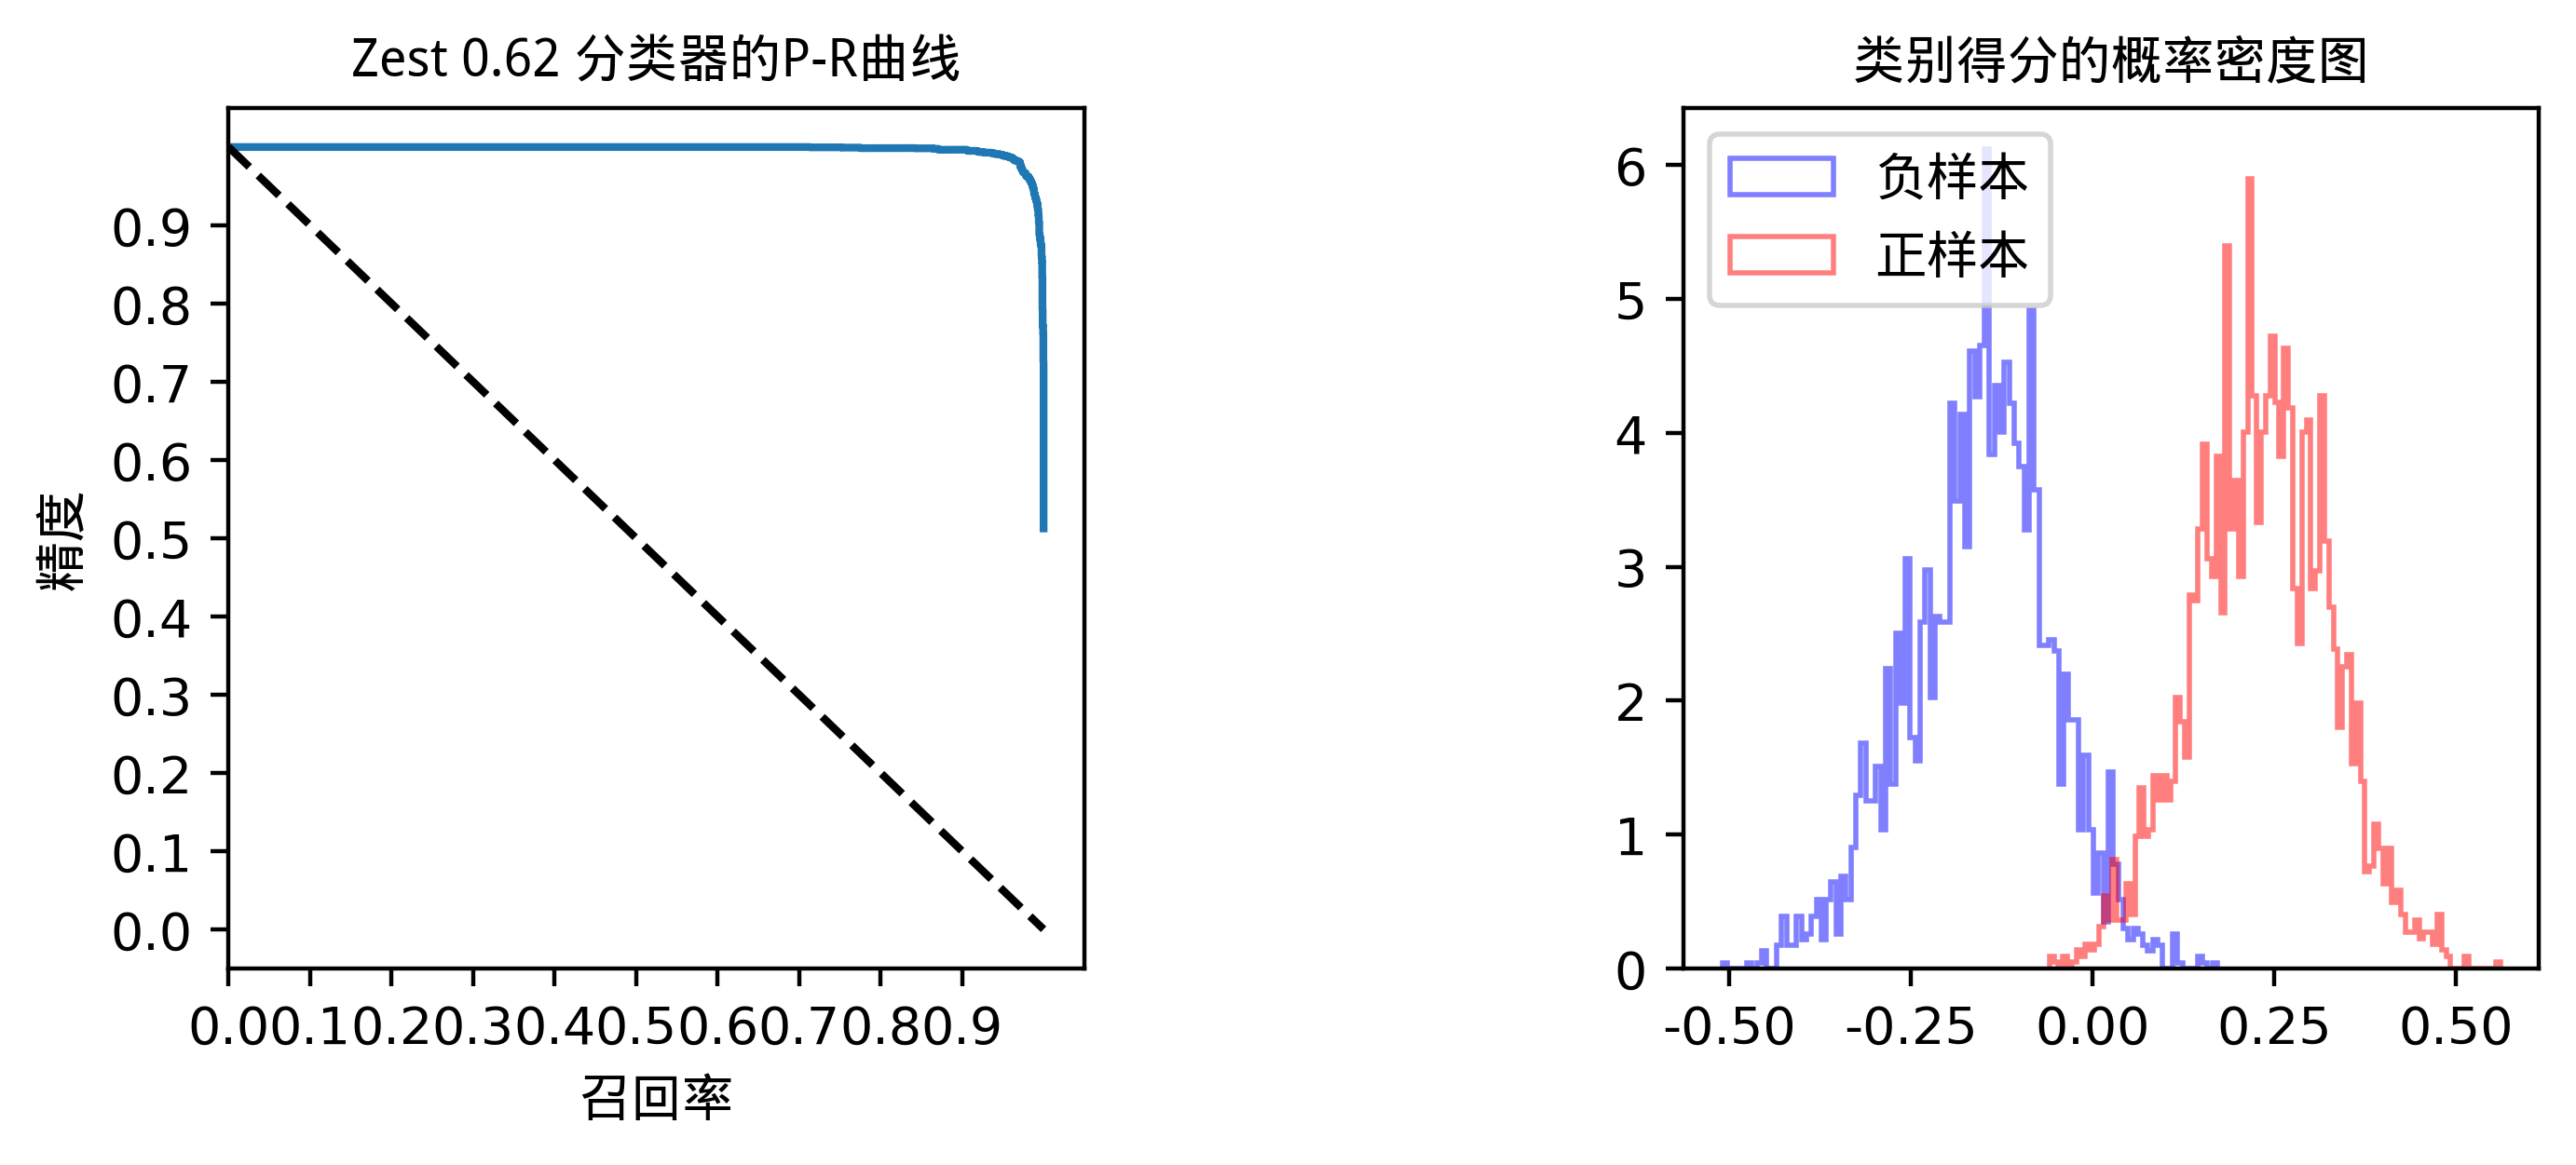

In [23]:
try:
    plot_PRcurve_and_scorePDF(scores_pos, scores_neg)
except AttributeError:
    print("")

In [24]:
def scatter_zstd_ratios(neg_nr, neg_pr, pos_nr, pos_pr):
    # 创建一个新的图形对象，设置分辨率为600dpi，大小为8x8英寸
    fig = plt.figure(dpi=600, figsize=(8, 8))
    # 设置字体
    myfont = font_manager.FontProperties(fname="/kaggle/input/chinese/DroidSansFallback.ttf")
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 创建第一个子图，显示负标签数据的散点图
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title('负标签', fontproperties=myfont)  # 设置标题
    ax1.set_xlabel('负率', fontproperties=myfont)  # 设置X轴标签
    ax1.set_ylabel('正率', fontproperties=myfont)  # 设置Y轴标签
    ax1.set_xticks(np.arange(0, 1.1, step=0.1))  # 设置X轴刻度
    ax1.set_yticks(np.arange(0, 1.1, step=0.1))  # 设置Y轴刻度
    ax1.scatter(neg_nr, neg_pr, s=1, marker='.', color='b', alpha=0.3)  # 绘制负标签的散点图，颜色为蓝色
    dots = np.linspace(0, 1, 60)  # 创建从0到1的60个等间距数据点
    ax1.scatter(dots, dots, s=5, marker='.', color='k')  # 绘制对角线（黑色）

    # 创建第二个子图，显示正标签数据的散点图
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title('正标签', fontproperties=myfont)  # 设置标题
    ax2.set_xlabel('负率', fontproperties=myfont)  # 设置X轴标签
    ax2.set_ylabel('正率', fontproperties=myfont)  # 设置Y轴标签
    ax2.set_xticks(np.arange(0, 1.1, step=0.1))  # 设置X轴刻度
    ax2.set_yticks(np.arange(0, 1.1, step=0.1))  # 设置Y轴刻度
    ax2.scatter(pos_nr, pos_pr, s=1, marker='.', color='r', alpha=0.3)  # 绘制正标签的散点图，颜色为红色
    ax2.scatter(dots, dots, s=5, marker='.', color='k')  # 绘制对角线（黑色）

    plt.show()

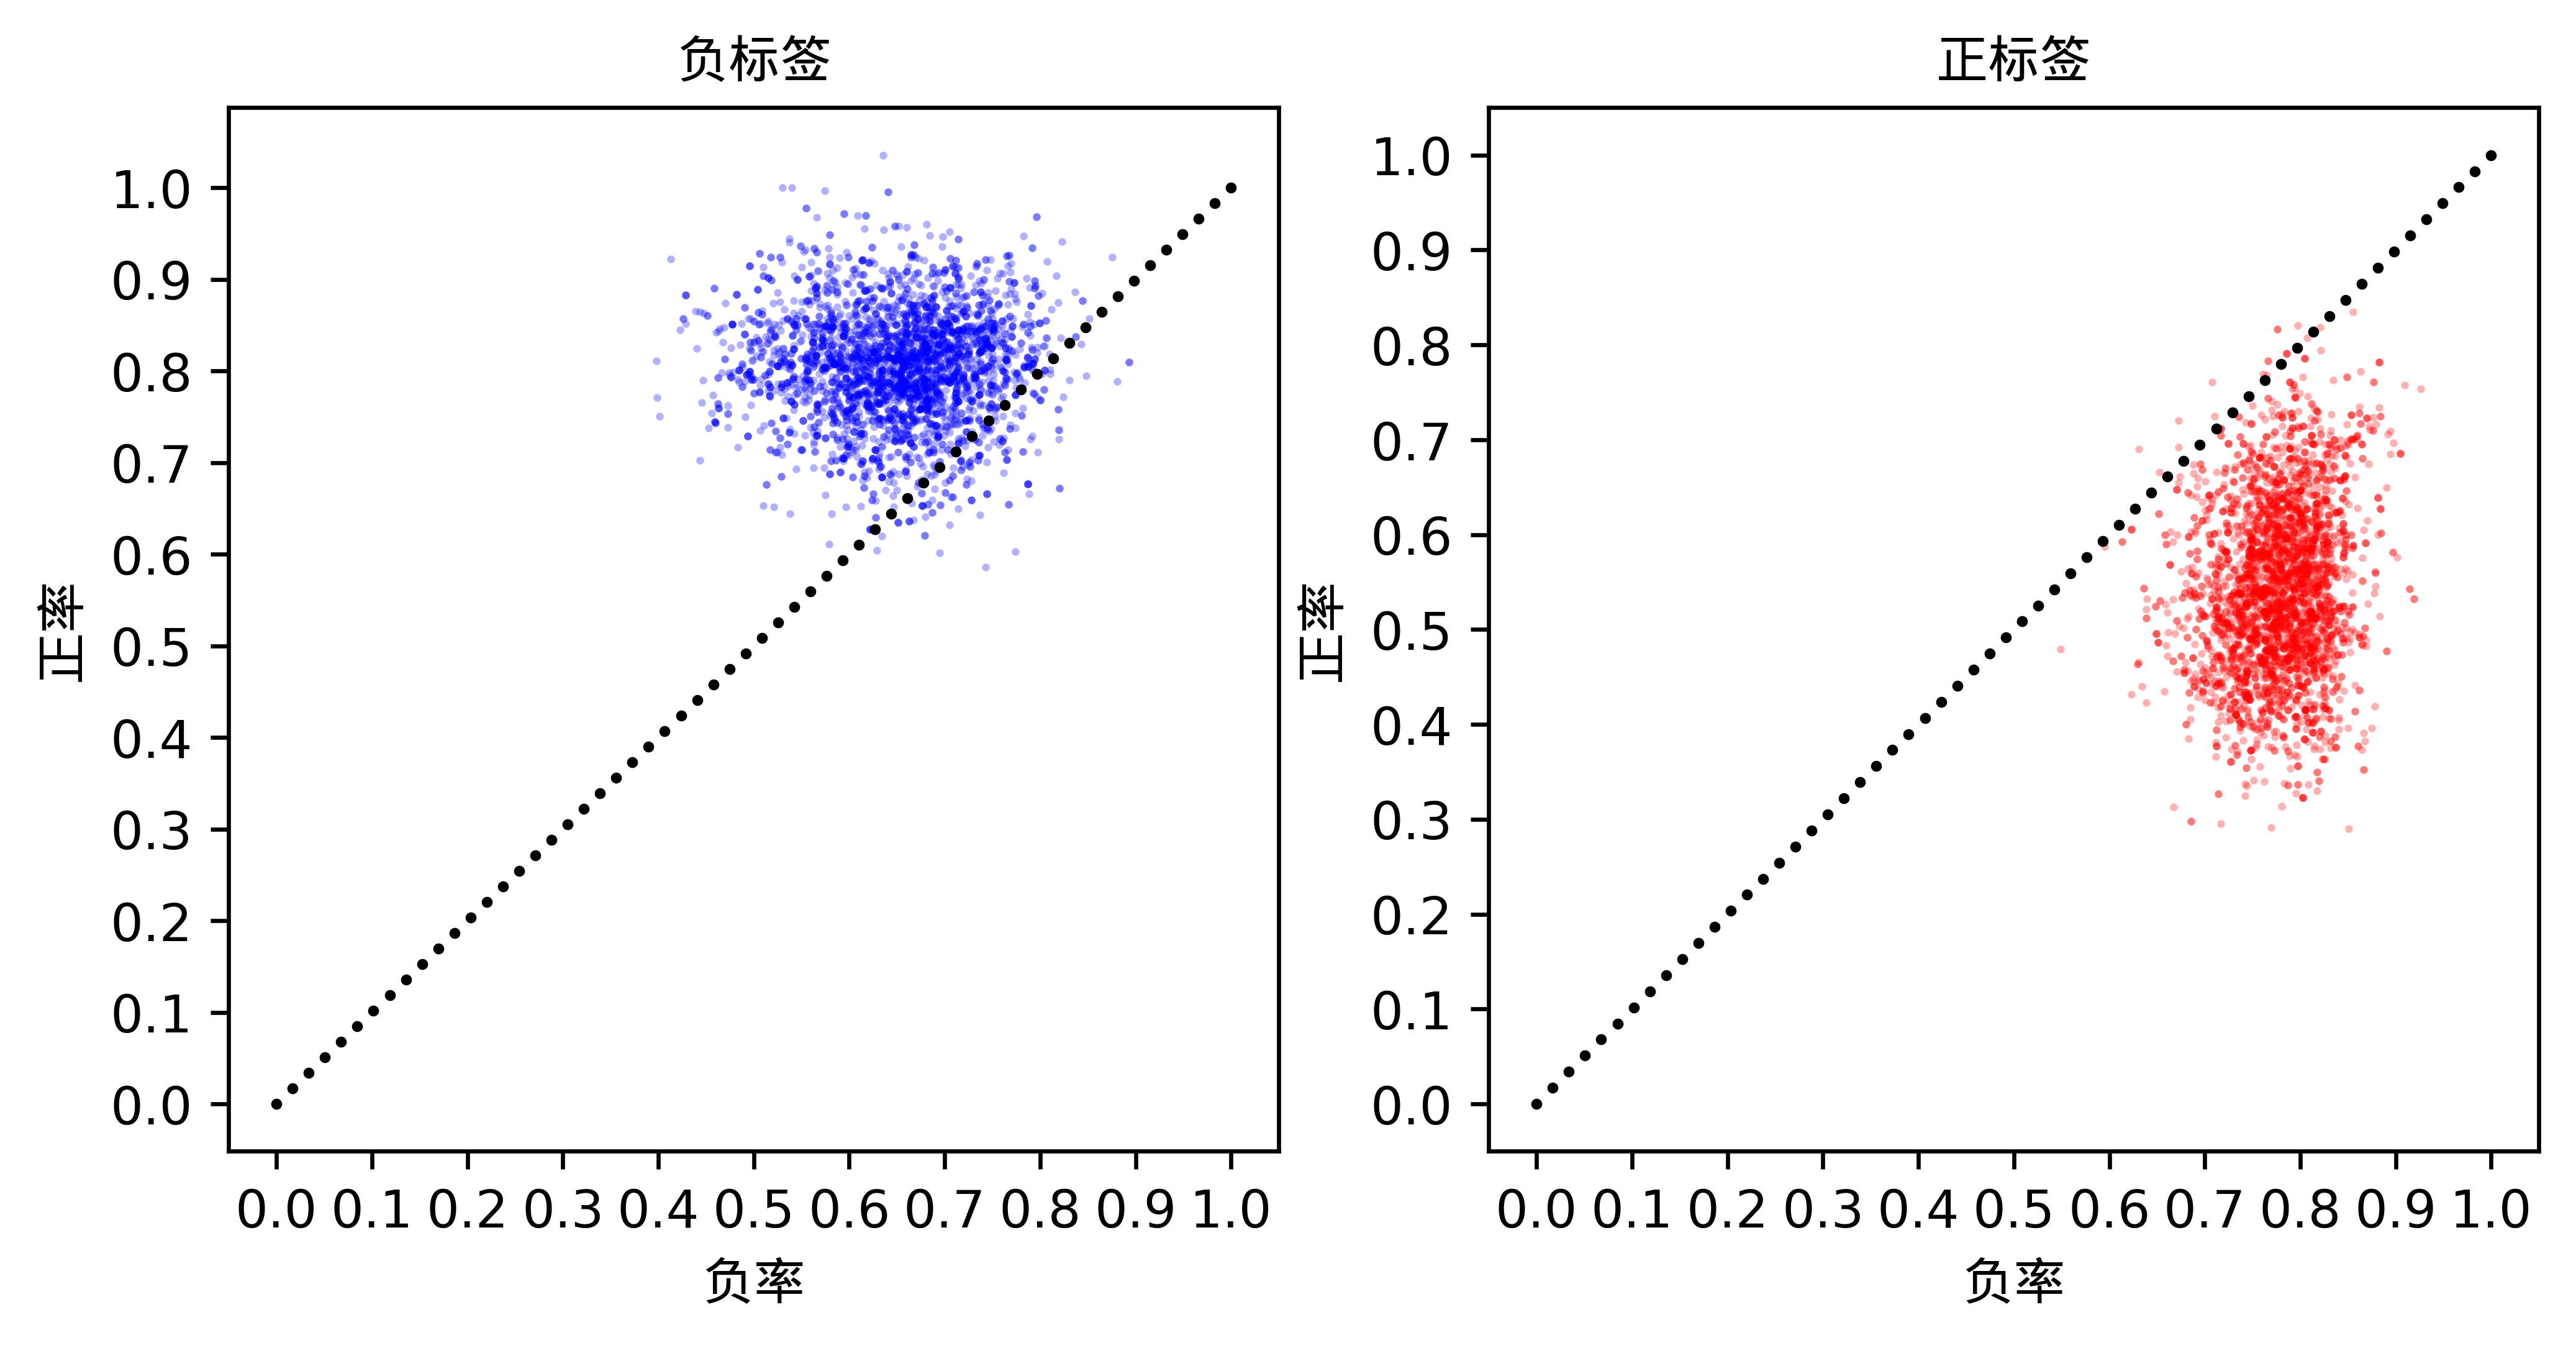

In [25]:
scatter_zstd_ratios(neg_nr, neg_pr, pos_nr, pos_pr)